# Growing Neural Cellular Automata

## Import

In [1]:
import jax
import jax.numpy as jnp
import mediapy
import optax
from cax.core.ca import CA
from cax.core.perceive.depthwise_conv_perceive import DepthwiseConvPerceive
from cax.core.perceive.kernels import grad_kernel, identity_kernel
from cax.core.state import state_from_rgba_to_rgb, state_to_rgba
from cax.core.update.nca_update import NCAUpdate
from cax.nn.pool import Pool
from cax.utils.image import get_emoji
from flax import nnx

## Configuration

In [ ]:
seed = 0

channel_size = 16
num_kernels = 3
hidden_size = 128
cell_dropout_rate = 0.5

pool_size = 1_024
batch_size = 8
num_steps = 128
learning_rate = 2e-3

emoji = "🦎"
target_size = 40
target_padding = 16

key = jax.random.PRNGKey(seed)
rngs = nnx.Rngs(seed)

## Dataset

""

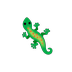

In [3]:
target = get_emoji(emoji, size=target_size, padding=target_padding)

mediapy.show_image(target)

## Init state

In [4]:
def init_state():
	state_shape = target.shape[:2] + (channel_size,)

	state = jnp.zeros(state_shape)
	mid = (size // 2 for size in state_shape[:-1])
	return state.at[*mid, -1].set(1.0)

## Model

In [5]:
perceive = DepthwiseConvPerceive(channel_size, rngs)
update = NCAUpdate(channel_size, num_kernels * channel_size, (hidden_size,), rngs, cell_dropout_rate=cell_dropout_rate)

In [6]:
kernel = jnp.concatenate([identity_kernel(ndim=2), grad_kernel(ndim=2)], axis=-1)
kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
perceive.depthwise_conv.kernel = nnx.Param(kernel)

In [7]:
ca = CA(perceive, update)

In [8]:
params = nnx.state(ca, nnx.Param)
print("Number of params:", jax.tree_util.tree_reduce(lambda x, y: x + y.size, params, 0))

Number of params: 8768


## Train

### Pool

In [9]:
state = jax.vmap(lambda _: init_state())(jnp.zeros(pool_size))

pool = Pool.create({"state": state})

### Optimizer

In [10]:
lr_sched = optax.linear_schedule(init_value=learning_rate, end_value=0.1 * learning_rate, transition_steps=2_000)

optimizer = optax.chain(
	optax.clip_by_global_norm(1.0),
	optax.adam(learning_rate=lr_sched),
)

update_params = nnx.All(nnx.Param, nnx.PathContains("update"))
optimizer = nnx.Optimizer(ca, optimizer, wrt=update_params)

### Loss

In [11]:
def mse(state):
	return jnp.mean(jnp.square(state_to_rgba(state) - target))

In [12]:
@nnx.jit
def loss_fn(ca, state, key):
	state = nnx.vmap(lambda state: ca(state, num_steps=num_steps, all_steps=True))(state)
	index = jax.random.randint(key, (state.shape[0],), num_steps // 2, num_steps)
	state = state[jnp.arange(state.shape[0]), index]
	loss = mse(state)
	return loss, state

### Train step

In [17]:
@nnx.jit
def train_step(ca, optimizer, pool, key):
	sample_key, loss_key = jax.random.split(key)

	# Sample from pool
	pool_index, batch = pool.sample(sample_key, batch_size=batch_size)
	current_state = batch["state"]

	# Sort by descending loss
	sort_index = jnp.argsort(jax.vmap(mse)(current_state), descending=True)
	pool_index = pool_index[sort_index]
	current_state = current_state[sort_index]

	# Sample a new target to replace the worst
	new_state = init_state()
	current_state = current_state.at[0].set(new_state)

	(loss, current_state), grad = nnx.value_and_grad(loss_fn, has_aux=True, argnums=nnx.DiffState(0, update_params))(
		ca, current_state, loss_key
	)
	optimizer.update(grad)

	pool = pool.update(pool_index, {"state": current_state})
	return loss, pool

### Main loop

In [ ]:
for i in range(8_192):
	key, subkey = jax.random.split(key)
	loss, pool = train_step(ca, optimizer, pool, subkey)
	if i % 128 == 0:
		print(f"Step {i}: loss = {loss}")

## Visualize

""

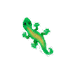

In [20]:
state = init_state()
state = ca(state, num_steps=2 * num_steps, all_steps=True)

mediapy.show_image(state_to_rgba(state[-1]))

""

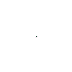

In [21]:
mediapy.show_video(state_from_rgba_to_rgb(state), width=128, height=128, codec="gif")